# Baseline (part 2)

Implementing second part of solution described here: 
"Franck Dernoncourt, Ji Young Lee, and Peter
Szolovits. 2016. Neural networks for joint sentence
classification in medical paper abstracts. European
Chapter of the Association for Computational Linguistics
(EACL) 2017."

In [1]:
import numpy as np
import pandas as pd
import os
import gc

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline  

Using TensorFlow backend.


## Get Data

In [2]:
# file PubMed_20k_RCT.csv created by script01_create_single_dataset
df_all = pd.read_csv('input/PubMed_20k_RCT.csv')
df_train = df_all[df_all['partition']=='train']
df_valid = df_all[df_all['partition']=='dev']
df_test = df_all[df_all['partition']=='test']
pd.set_option('max_colwidth',500)
df_all.head()

,partition,abstract_id,seq,text,label
0,train,4293578,0,"To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .",OBJECTIVE
1,train,4293578,1,A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .,METHODS
2,train,4293578,2,Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .,METHODS
3,train,4293578,3,Pain was assessed using the visual analog pain scale ( 0-100 mm ) .,METHODS
4,train,4293578,4,"Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .",METHODS


In [3]:
X_train_cnt = df_train.shape[0]
X_valid_cnt = df_valid.shape[0]
X_test_cnt = df_test.shape[0]

X_all = df_all.text.values

print('Train partition size: {}'.format(X_train_cnt))
print('Valid partition size: {}'.format(X_valid_cnt))
print('Test partition size: {}'.format(X_test_cnt))
print('Total dataset size: {}'.format(X_all.shape[0]))

Train partition size: 180040
Valid partition size: 30212
Test partition size: 30135
Total dataset size: 240387


## Create token sequences

In [4]:
%%time

# reduce vocabulary size to make problem manageable for available computing resources
#SEQ_VOC = 50000
#print('Number of tokens for sequences = {}'.format(SEQ_VOC))

#tokenizer = Tokenizer(num_words=VOC_SIZE, filters='!"*,./:;?@\`|')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_all)
sequences = tokenizer.texts_to_sequences(X_all)

word_index = tokenizer.word_index
VOC_SIZE = len(word_index)
print('Vocabulary size = {}'.format(VOC_SIZE))

Vocabulary size = 67356
CPU times: user 26.5 s, sys: 265 ms, total: 26.8 s
Wall time: 1min 13s


In [5]:
MAX_SEQ_LEN = 50
X_token_seq_all = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, dtype='int32', padding='pre', truncating='post', value=0)

## Vectorize output labels

In [6]:
%%time

y_labels = df_all.label.values

# create label set and add 'PAD' to the set
label_set = set(y_labels)
label_set.add('PAD')
label_dict = {label: no for no, label in enumerate(label_set)}
number_of_classes = len(label_dict)

# get inverted dict
label_dict_inv = {no: label for label, no in label_dict.items()}

# get labels as integers
y_all = [label_dict[label] for label in y_labels]

# change y to categorical (vectorize output)
y_all = np.array([to_categorical(i, num_classes=number_of_classes) for i in y_all])

print(y_all.shape)

(240387, 6)
CPU times: user 4.61 s, sys: 174 ms, total: 4.79 s
Wall time: 13.7 s


## Prepare embedding layer with pre-trained glove word vectors

I use glove pre-trained (on Twiter) embeddings. <br> 
My code follows guidelines from Keras tutorial: <br>
https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [7]:
%%time

# read pre-trained glove embeddings

# create dictionary with word embeddings
embedding_file = {}
embedding_file[25] = 'glove/glove.twitter.27B.25d.txt'
embedding_file[50] = 'glove/glove.twitter.27B.50d.txt'
embedding_file[100] = 'glove/glove.twitter.27B.100d.txt'
embedding_file[200] = 'glove/glove.twitter.27B.200d.txt'

# set embedding dimension
EMBEDDING_DIM = 200

embeddings_index = {}
print('Using embedding dim = {}'.format(EMBEDDING_DIM))

f = open(embedding_file[EMBEDDING_DIM], 'r')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Number of word vectors found: {}'.format(len(embeddings_index)))

Using embedding dim = 200
Number of word vectors found: 1193514
CPU times: user 2min 28s, sys: 5.81 s, total: 2min 34s
Wall time: 6min 55s


In [8]:
%%time

# create matrix with embedding coefs for each word in vocabulary
# row position of word representation in the matrix will be the word number

# initiazes matrix with zeros
embedding_matrix = np.zeros((VOC_SIZE + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

CPU times: user 284 ms, sys: 410 ms, total: 693 ms
Wall time: 1.87 s


## Create dense vector representation of sentences for training

First will train part 2 of the model by obtaining output from intermediary layer from model 1

In [9]:
%%time

# read model that creates vector representation of sentences

from keras.models import load_model

model_1 = load_model('input/Baseline_Part1_Bi-LSTM_MLP.h5')

model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 200)           13471400  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1600)              6406400   
_________________________________________________________________
sentence_vector_1 (Dense)    (None, 100)               160100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
sentence_vector_2 (Dense)    (None, 20)                2020      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
__________

In [10]:
%%time

# get tensor representation of sentences as output from layer "sentence_vector_2"

from keras.models import Model

layer_name = 'sentence_vector_1'
intermediate_layer_model = Model(inputs=model_1.input, outputs=model_1.get_layer(layer_name).output)

# get tensor representation of training partition
sentence_train = intermediate_layer_model.predict(X_token_seq_all[:X_train_cnt])

# get tensor representation of validation partition
sentence_valid = intermediate_layer_model.predict(X_token_seq_all[X_train_cnt:(X_train_cnt+X_valid_cnt)])

# get tensor representation of test partition
sentence_test = intermediate_layer_model.predict(X_token_seq_all[-X_test_cnt:])

# concat all data
sentence_all = np.vstack((sentence_train, sentence_valid, sentence_test))

print(sentence_train.shape)
print(sentence_valid.shape)
print(sentence_test.shape)
print(sentence_all.shape)

(180040, 100)
(30212, 100)
(30135, 100)
(240387, 100)
CPU times: user 5h 2min 35s, sys: 13min 13s, total: 5h 15min 49s
Wall time: 1h 3min 46s


## Create sentence and label sequences

Total number of abstracts = 20000
Max abstract size = 31


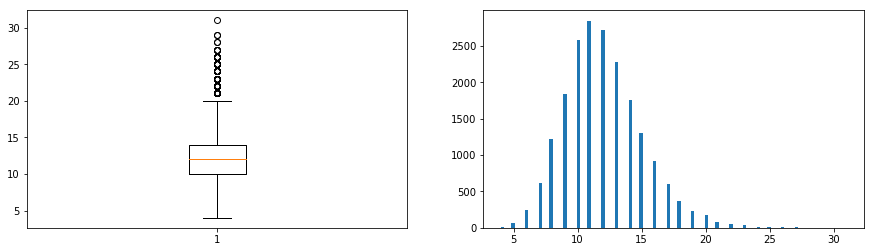

In [11]:
# find size of abstracts

# create dataframe with abstract lengths
abstract_lens = df_all[['abstract_id','text']].groupby(by='abstract_id').agg('count')

# create dict with abstract lengths
abstract_len_dict = {abstract_id: length for abstract_id, length in abstract_lens.reset_index().values}

print('Total number of abstracts = {}'.format(len(abstract_lens.index)))
print('Max abstract size = {}'.format(np.max(abstract_lens.text.values)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
axes[0].boxplot(abstract_lens.text.values)
axes[1].hist(abstract_lens.text.values, bins=100)
plt.show()

In [12]:
%%time

# Get abstract and label sequences

def get_abstract_seq(sentence_arry, i, j):
    # create flattened array with sentences for this abstract
    sentences = sentence_arry[i:j].flatten()
    # create enough zero padding to reach 31 sentences, the max no of sentences for abstract in dataset
    left_padding  = np.zeros(100 * (31 - (j - i)))
    # pad left
    full_abstract = np.hstack((left_padding, sentences))
    # abstract must be 31 sentences long, and each sentence has len 100
    assert len(full_abstract) == 3100
    return full_abstract

def get_label_seq(label_arry, pad, i, j):
    # create flattened array with sentences for this abstract
    labels = label_arry[i:j].flatten()
    # create enough zero padding to reach 31 sentences, the max no of sentences for abstract in dataset
    left_padding  = np.array(list(pad) * (31 - (j - i)))
    # pad left
    full_labels = np.hstack((left_padding, labels))
    # abstract must be 31 sentences long, and each sentence has len 100
    assert len(full_labels) == 31 * 6
    return full_labels

# create lists to store abstracts and label sequence for abstracts
abstracts = list()
labels = list()
sorted_abs_id = list()

# find categorial 
y_PAD = to_categorical(label_dict['PAD'], num_classes=number_of_classes)

i = 0
while True:
    
    # find number of sentences in abstract
    abs_id = df_all.abstract_id.values[i]
    # save district abstract ids, in the order they appear in the dataset
    sorted_abs_id.append(abs_id)
    abs_len = abstract_len_dict[abs_id]
    j = i + abs_len
    
    # get flattened sentences that make up abstract
    abstracts.append(get_abstract_seq(sentence_all, i, j))
    
    # get flattened labels that make up abstract labels
    labels.append(get_label_seq(y_all, y_PAD, i, j))
    
    i = j
    if j >= len(df_all.index):
        print('Done!')
        break
        
print('Number of abstracts: {}'.format(len(abstracts)))
print('Number of label seqs: {}'.format(len(labels)))

print('\nNumber of abstracts in each partition: \n{}'.format(df_all.groupby(by=('partition')).abstract_id.nunique()))

Done!
Number of abstracts: 20000
Number of label seqs: 20000

Number of abstracts in each partition: 
partition
dev       2500
test      2500
train    15000
Name: abstract_id, dtype: int64
CPU times: user 1.19 s, sys: 229 ms, total: 1.42 s
Wall time: 1.47 s


In [13]:
# restore partition data

X_all = np.array(abstracts)
X_all = X_all.reshape(X_all.shape[0],31,100)
X_train = X_all[:15000]
X_valid = X_all[15000:17500]
X_test  = X_all[-2500:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

y_seq_all = np.array(labels)
y_seq_all = y_seq_all.reshape(y_seq_all.shape[0],31,6)
y_seq_train = y_seq_all[:15000]
y_seq_valid = y_seq_all[15000:17500]
y_seq_test  = y_seq_all[-2500:]

print(y_seq_train.shape)
print(y_seq_valid.shape)
print(y_seq_test.shape)

(15000, 31, 100)
(2500, 31, 100)
(2500, 31, 100)
(15000, 31, 6)
(2500, 31, 6)
(2500, 31, 6)


## Train model

In [14]:
%%time

from keras.layers import Embedding, Input, LSTM, Flatten, Dropout, Dense, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping

abs = Input(shape=(X_all.shape[1], X_all.shape[2]), dtype='float32')
lstm = Bidirectional(LSTM(units=100, return_sequences=True))(abs)
out = TimeDistributed(Dense(6, activation="softmax"))(lstm) 

model_2 = Model(abs, out)
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model_2.summary()

# learn
model_2.fit(X_train, y_seq_train, validation_data=(X_valid, y_seq_valid), \
          callbacks=[EarlyStopping(patience=1, monitor='val_loss')], \
          verbose=1, epochs=20, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 31, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 31, 200)           160800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 31, 6)             1206      
Total params: 162,006
Trainable params: 162,006
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 2500 samples
Epoch 1/20
15000/15000 [==============================] - 14s 919us/step - loss: 0.1598 - acc: 0.9556 - val_loss: 0.1098 - val_acc: 0.9597
Epoch 2/20
15000/15000 [==============================] - 12s 781us/step - loss: 0.0765 - acc: 0.9700 - val_loss: 0.1041 - val_acc: 0.9611
Epoch 3/20
15000/15000 [==============================] - 12s 805us/step 

## Save model

In [15]:
model_2.save('input/Baseline_Part2_Bi-LSTM_MPL_BLSTM.h5')

## Calculate accuracy on test set

In [16]:
from sklearn.metrics import accuracy_score

preds = model_2.predict(X_test)
y_seq_hat = np.argmax(preds, axis=-1).flatten()

y_seq_true = np.argmax(y_seq_test, axis=-1).flatten()

acc = accuracy_score(y_seq_true, y_seq_hat)
print('Accuracy on test partition (padded label sequence): {}'.format(acc))

Accuracy on test partition (padded label sequence): 0.9623612903225807


In [17]:
preds = model_2.predict(X_test)
y_seq_hat = np.argmax(preds, axis=-1)
y_seq_true = np.argmax(y_seq_test, axis=-1)

#print(y_seq_hat.shape)
#print(y_seq_true.shape)

y_seq_hat_trimmed = list()
y_seq_true_trimmed = list()
i = 0
for abs_id in sorted_abs_id[-2500:]:
    x = list(y_seq_hat[i][-abstract_len_dict[abs_id]:])
    while len(x) > 0:
        y_seq_hat_trimmed.insert(0, x.pop())
    x = list(y_seq_true[i][-abstract_len_dict[abs_id]:])
    while len(x) > 0:
        y_seq_true_trimmed.insert(0, x.pop())    
    i += 1
    
#print(len(y_seq_hat_trimmed))
#print(len(y_seq_true_trimmed))

acc = accuracy_score(y_seq_true_trimmed, y_seq_hat_trimmed)
print('Accuracy on test partition (no padding): {}'.format(acc))

Accuracy on test partition (no padding): 0.9032022565123611


In [18]:
from sklearn.metrics import f1_score

f1_score(y_seq_true_trimmed, y_seq_hat_trimmed, average='micro')

0.90320225651236108